In [4]:
## Here we will code losses 

# pytorch imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import gc

# image transformations
import torchvision.transforms as transforms

# torch vision imports
from torchvision.models import vgg19,VGG19_Weights
from torch.utils.data import Dataset, DataLoader

# PIL imports and cv
from PIL import Image
import cv2 as cv
import os

# matplotlib imports
import matplotlib.pyplot as plt
import numpy

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
test_fake_image = Image.open('samples/new_results/wednesday-5.jfif').convert('RGB')
test_anime_image = Image.open('samples/new_results/wednesday-5.jfif').convert('RGB')
test_anime_gray = Image.open('samples/new_results/wednesday-5.jfif').convert('L')

transformations = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
    
    # converting image to -1 to 1
    transforms.Normalize(mean = 0,std = 0.5),
    transforms.Normalize(mean = 1, std = 1),

])

test_image = transformations(test_anime_image).unsqueeze(0)
test_image.shape

torch.Size([1, 3, 224, 224])

## Vgg19 features extraction

In [3]:
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT).features[:35].to(device)

In [47]:
vgg19_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [74]:
class vgg19_features(nn.Module):

    def __init__(self, model, layers = [0,1,3,5,7] ):

        super(vgg19_features, self).__init__()
        # defining the required layers and the vgg19 model here
        self.model = model
        self.req_layers = layers
    
    def forward(self, input):

        # transforming the inputs according to the vgg 19 pretrained transformations
        x = self.vgg_19_transforms(input)

        self.layer_features = []
        conv_layer_num = 0

        for layer_num,layer in enumerate(self.model) : 

            # iterating through all layer and getting the required layers
            x = layer(x)

            # checking if the layer is a conv layer
            if isinstance(layer, nn.Conv2d):

                # appending if we had that layer in required layers
                if conv_layer_num in self.req_layers :
                    self.layer_features.append(x)
                
                conv_layer_num += 1
        
        return self.layer_features
    
    def vgg_19_transforms(self, input):

        # as input is from (-1,1)
        input = (input + 1)/2

        # transforming according to the vgg pre trained requirements
        vgg_mean = torch.tensor([[0.485], [0.456], [0.406]], dtype = torch.float32).to(input.device)
        vgg_std  = torch.tensor([[0.229], [0.224], [0.225]], dtype = torch.float32).to(input.device)

        # print(vgg_mean.view(-1, 1 ,1).shape)

        # returning the image
        return (input - vgg_mean.view(-1, 1 ,1)) / vgg_std.view(-1, 1 ,1)

In [75]:
testing_vgg19_features = vgg19_features(vgg19_model).to(device)

In [76]:
features = testing_vgg19_features(test_image.to(device))

In [77]:
print(f"printing the features shapes")
[f.shape for f in features]

printing the features shapes


[torch.Size([1, 64, 224, 224]),
 torch.Size([1, 64, 224, 224]),
 torch.Size([1, 128, 112, 112]),
 torch.Size([1, 256, 56, 56]),
 torch.Size([1, 256, 56, 56])]

In [ ]:
# ------------------------------ Testing Done ---------------------------------------------

## Losses

In [84]:
class ColorLoss(nn.Module):

    def __init__(self,):

        super(ColorLoss, self).__init__()

        # kernel used to convert rgb to yuv
        self._rgb_to_yuv_kernel = torch.tensor([
                [0.299, -0.14714119, 0.61497538],
                [0.587, -0.28886916, -0.51496512],
                [0.114, 0.43601035, -0.10001026]
            ]).float()
        
        self.l1 = nn.L1Loss()
        self.huber = nn.SmoothL1Loss()
    
    def rgb_to_yuv(self,image):
        '''
        https://en.wikipedia.org/wiki/YUV

        output: Image of shape (H, W, C) (channel last)
        '''
        # -1 1 -> 0 1
        image = (image + 1.0) / 2.0

        yuv_img = torch.tensordot(
            image,
            self._rgb_to_yuv_kernel,
            dims=([image.ndim - 3], [0]))

        return yuv_img
    
    def forward(self, generator_image, content_image):
        
        # Now converting the image to other format
        image = self.rgb_to_yuv(content_image)
        image_g = self.rgb_to_yuv(generator_image)

        # After convert to yuv, both images have channel last
        return (self.l1( image_g[:, :, :, 0], image[:, :, :, 0]) +
                self.huber( image_g[:, :, :, 1], image[:, :, :, 1]) +
                self.huber( image_g[:, :, :, 2], image[:, :, :, 2]) )

In [85]:
class AnimeGanLoss():

    def __init__(self, args, device):

        # defining losses going to be used
        self.content_loss = nn.L1Loss().to(device)
        self.gram_loss = nn.L1Loss().to(device)
        self.color_loss = ColorLoss().to(device)

        # coefficient of losses 
        self.wadvg = args['wadvg']
        self.wadvd = args['wadvd']
        self.wcon = args['wcon']
        self.wgra = args['wgra']
        self.wcol = args['wcol']
        self.sharp = 0.2 if 'sharp' not in args else args['sharp']
        
        # Loss type for discriminator
        self.adv_type = args['gan_loss'].lower() if 'gan_loss' in args else 'lsgan'
        self.bce_loss = nn.BCELoss()
    
    # to calculate the gram matrix
    def get_gram(self, image):
        """
        Calculate Gram Matrix

        https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#style-loss
        """
        b, c, w, h = image.size()

        # calculating the gram matrix
        x = image.view(b * c, w * h)
        G = torch.mm(x, x.T)

        # normalize by total elements
        return G.div(b * c * w * h)
    
    # for computing the generator loss
    def compute_generator_loss(self, generated_image, original_image, generated_image_logits,
                               generator_image_content_features, original_image_content_features, 
                               generator_style_feat, anime_gray_style_feat):
        
        # generated_image, original_image, # -> to calculate the color loss
        # generator_image_content_features, original_image_content_features, # -> for the content_loss
        # generator_style_feat, anime_gray_style_feat # -> for the style loss

        # color loss
        color_loss = self.wcol * self.color_loss(generated_image, original_image,)

        # content loss
        content_loss = self.wcon * sum([ self.content_loss(g_feat, org_feat) for g_feat,org_feat in zip(generator_image_content_features, original_image_content_features) ])

        # style loss
        style_loss = self.wgra * sum([ self.gram_loss(self.get_gram(g_feat), self.get_gram(org_feat)) for g_feat,org_feat in zip(generator_style_feat, anime_gray_style_feat) ])

        # generated image discriminator loss
        g_adv_loss = self.wadvg * self.adv_loss_g(generated_image_logits)

        return [color_loss, content_loss, style_loss, g_adv_loss]
    
    # loss for discriminator
    def compute_discriminator_loss(self, generated_logits, anime_logits,
                                   anime_gray_logits, anime_smooth_logits):
        
        # computing fake discriminator losses
        g_loss = self.wadvd * self.adv_loss_d_fake(generated_logits)
        anime_smooth = self.wadvd * self.adv_loss_d_fake(anime_smooth_logits) * self.sharp 
        anime_gray = self.wadvd * self.adv_loss_d_fake(anime_gray_logits)

        # computing real discriminator losses
        anime_real = self.adv_loss_d_real(anime_logits) * self.wadvd

        return [g_loss, anime_smooth, anime_gray, anime_real]

    # adv loss for discriminator
    def adv_loss_d_real(self, pred):
        if self.adv_type == 'hinge':
            return torch.mean(F.relu(1.0 - pred))

        elif self.adv_type == 'lsgan':
            return torch.mean(torch.square(pred - 1.0))

        elif self.adv_type == 'normal':
            return self.bce_loss(pred, torch.ones_like(pred))

        raise ValueError(f'Do not support loss type {self.adv_type}')
    
    # adv loss for discriminator
    def adv_loss_d_fake(self, pred):
        if self.adv_type == 'hinge':
            return torch.mean(F.relu(1.0 + pred))

        elif self.adv_type == 'lsgan':
            return torch.mean(torch.square(pred))

        elif self.adv_type == 'normal':
            return self.bce_loss(pred, torch.zeros_like(pred))

        raise ValueError(f'Do not support loss type {self.adv_type}')

    # adv loss for generator
    def adv_loss_g(self, pred):
        if self.adv_type == 'hinge':
            return -torch.mean(pred)

        elif self.adv_type == 'lsgan':
            return torch.mean(torch.square(pred - 1.0))

        elif self.adv_type == 'normal':
            return self.bce_loss(pred, torch.ones_like(pred))

        raise ValueError(f'Do not support loss type {self.adv_type}')

In [86]:
class LossSummary:
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss_g_adv = []
        self.loss_content = []
        self.loss_gram = []
        self.loss_color = []
        self.loss_d_adv = []

    def update_loss_G(self, adv, gram, color, content):
        self.loss_g_adv.extend(adv.cpu().detach().numpy())
        self.loss_gram.extend(gram.cpu().detach().numpy())
        self.loss_color.extend(color.cpu().detach().numpy())
        self.loss_content.extend(content.cpu().detach().numpy())

    def update_loss_D(self, loss):
        self.loss_d_adv.extend(loss.cpu().detach().numpy())

    def avg_loss_G(self):
        return (
            self._avg(self.loss_g_adv),
            self._avg(self.loss_gram),
            self._avg(self.loss_color),
            self._avg(self.loss_content),
        )
    
    def plot_loss(self):

        # plotting the losses
        plt.figure(figsize=(12,20))
        for loss in [self.loss_g_adv, self.loss_content, self.loss_gram, self.loss_color, self.loss_d_adv]:
            plt.subplot(2, 3, loss)
        
        # plotting
        plt.plot()

    def avg_loss_D(self):
        return self._avg(self.loss_d_adv)


    @staticmethod
    def _avg(losses):
        return sum(losses) / len(losses)

## Anime Gan Dataset

In [27]:
class AnimeDataSet(Dataset):

    def __init__(self, args, ):

        """   
        folder structure:
            - {data_dir}
                - photo
                    1.jpg, ..., n.jpg
                - {dataset}  # E.g Hayao
                    smooth
                        1.jpg, ..., n.jpg
                    style
                        1.jpg, ..., n.jpg
        """

        # getting the path for the dataset
        self.data_dir = args['data_dir']
        self.dataset_name = args['dataset']
        self.size = args['size']
        self.train_path = args['train']
        self.required_length = args['required_length'] if 'required_length' in args else None

        dataset = self.dataset_name
        data_dir = self.data_dir

        # getting the path for training image and all images in the training data
        self.train_dir = os.path.join(self.data_dir,'train_photo')
        self.train_images_path = [ os.path.join(self.train_dir,p) for p in os.listdir(self.train_dir) ]

        # getting the anime path
        self.anime_dir = os.path.join(data_dir, dataset)
        self.anime_smooth = os.path.join(self.anime_dir,'smooth')
        self.anime_real = os.path.join(self.anime_dir,'style')

        if not os.path.exists(data_dir):
            raise FileNotFoundError(f'Folder {data_dir} does not exist')

        if not os.path.exists(self.anime_dir):
            raise FileNotFoundError(f'Folder {self.anime_dir} does not exist')

        # obtaining the path of all anime images
        self.anime_real_images_path = [ os.path.join(self.anime_real,p) for p in os.listdir(self.anime_real) ]
        self.anime_smooth_images_path = [ os.path.join(self.anime_smooth,p) for p in os.listdir(self.anime_smooth) ]
        self.anime_len = len(self.anime_real_images_path)

        # self.mean = compute_data_mean(os.path.join(anime_dir, 'style'))
        # print(f'Mean(B, G, R) of {dataset} are {self.mean}')

        # -> while loading we need to load the smooth image, anime_real, anime_gray, train_image
            
    def get_train_image(self, index):
        # load image
        img = Image.open(self.train_images_path[index])

        # convert to (-1,1)
        self.train_transforms = transforms.Compose([
            transforms.Resize(size = self.size),
            transforms.ToTensor(), # (0,1)
            transforms.Normalize(mean = 0, std = 0.5), # (0,2)
            transforms.Normalize(mean = 1, std = 1), # (-1,1)
        ])
        img = self.train_transforms(img)

        return img

    def get_anime_real(self, index):
        # load image
        anime_img = Image.open(self.anime_real_images_path[index])

        # convert to (-1,1) , same transformation here as well
        anime_img = self.train_transforms(anime_img)
        
        return anime_img

    def get_anime_gray(self, index):
        # load image
        img = Image.open(self.anime_real_images_path[index]).convert('L')
        
        # convert to grayscale
        # convert to (-1,1)
        # then repeat same channel 3 time to make it as a 3 channel image
        self.anime_gray_transforms = transforms.Compose([
            transforms.Resize(size = self.size),
            transforms.ToTensor(), # (0,1)
            transforms.Normalize(mean = 0, std = 0.5), # (0,2)
            transforms.Normalize(mean = 1, std = 1), # (-1,1)
        ])
        img = self.anime_gray_transforms(img)
        img = img.repeat(3,1,1)

        return img

    def get_anime_smooth(self, index):
        # load image
        img = Image.open(self.anime_smooth_images_path[index]).convert('L')
        
        # convert to grayscale
        # convert to (-1,1)
        # then repeat same channel 3 time to make it as a 3 channel image
        img = self.anime_gray_transforms(img)
        img = img.repeat(3,1,1)

        return img

    def __len__(self):
        return min( len(self.train_images_path), self.required_length ) if self.required_length != None else len(self.train_images_path)
    
    def __getitem__(self, index) :
        
        # getting the anime image index
        anime_index = index % self.anime_len

        # if the required length is less, we need to use our dataset extensively by randomly sampling
        if self.__len__() != len(self.train_images_path):

            # probability of selecting the image with the index 
            prob = self.required_length / len(self.train_images_path)

            # creating a random number to select a image and selecting a index based on that
            decider = np.random.random()
            index = index if decider < prob else np.random.randint(low = index, high = len(self.train_images_path), size = 1 )[0]
            anime_index = index % self.anime_len
        
            # print(index)

        # getting all the images 
        train_image = self.get_train_image(index)
        anime_real = self.get_anime_real(anime_index)
        anime_gray = self.get_anime_gray(anime_index)
        anime_smooth = self.get_anime_smooth(anime_index)

        return [train_image, anime_real, anime_gray, anime_smooth]

In [30]:
### testing data lader
dataset_args = {'data_dir': './dataset/dataset/', 'dataset' : 'Hayao', 'size' : (256,256), 'required_length' : 100, 'train' : 'india_train'}
anime_data = DataLoader(AnimeDataSet(dataset_args), batch_size = 10, shuffle = True, drop_last = False)

In [29]:
len(anime_data)

10

In [44]:
# # so it passed the test
# anime_data = DataLoader(AnimeDataSet(dataset_args), batch_size = 10, shuffle = True, drop_last = False)

# for batch in anime_data:

#     print(batch.__len__())

#     # printing size
#     print(batch[0].shape, batch[0].shape, batch[0].shape, batch[0].shape)
#     print(batch[0].max(), batch[0].min(), batch[1].max())

#     # printing the image
#     plt.imshow(transforms.ToPILImage()( (batch[0][0]+1)*0.5 ))

#     break

## Selective style transfer

In [12]:
from tqdm.notebook import tqdm

In [9]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation

extractor = AutoFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

C:\Users\pcdpm\AppData\Roaming\Python\Python310\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\pcdpm\AppData\Roaming\Python\Python310\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [10]:
seg_config = model.config

In [11]:
seg_config.label2id

{'airplane': 90,
 'animal': 126,
 'apparel': 92,
 'arcade machine': 78,
 'armchair': 30,
 'ashcan': 138,
 'awning': 86,
 'bag': 115,
 'ball': 119,
 'bannister': 95,
 'bar': 77,
 'barrel': 111,
 'base': 40,
 'basket': 112,
 'bathtub': 37,
 'bed ': 7,
 'bench': 69,
 'bicycle': 127,
 'blanket': 131,
 'blind': 63,
 'boat': 76,
 'book': 67,
 'bookcase': 62,
 'booth': 88,
 'bottle': 98,
 'box': 41,
 'bridge': 61,
 'buffet': 99,
 'building': 1,
 'bulletin board': 144,
 'bus': 80,
 'cabinet': 10,
 'canopy': 106,
 'car': 20,
 'case': 55,
 'ceiling': 5,
 'chair': 19,
 'chandelier': 85,
 'chest of drawers': 44,
 'clock': 148,
 'coffee table': 64,
 'column': 42,
 'computer': 74,
 'conveyer belt': 105,
 'counter': 45,
 'countertop': 70,
 'cradle': 117,
 'crt screen': 141,
 'curtain': 18,
 'cushion': 39,
 'desk': 33,
 'dirt track': 91,
 'dishwasher': 129,
 'door': 14,
 'earth': 13,
 'escalator': 96,
 'fan': 139,
 'fence': 32,
 'field': 29,
 'fireplace': 49,
 'flag': 149,
 'floor': 3,
 'flower': 66,


In [11]:
# extracted inputs
test_img = Image.open('../../All Content Image/collected_images/actor 1.jpg').convert('RGB')
extracted_inputs = extractor(images=test_img, return_tensors="pt")

# getting the outputs
segmentation_model = model.to(device)
outputs = segmentation_model(**extracted_inputs.to(device))

# getting the logits
logits = outputs.logits

del test_img
gc.collect()

0

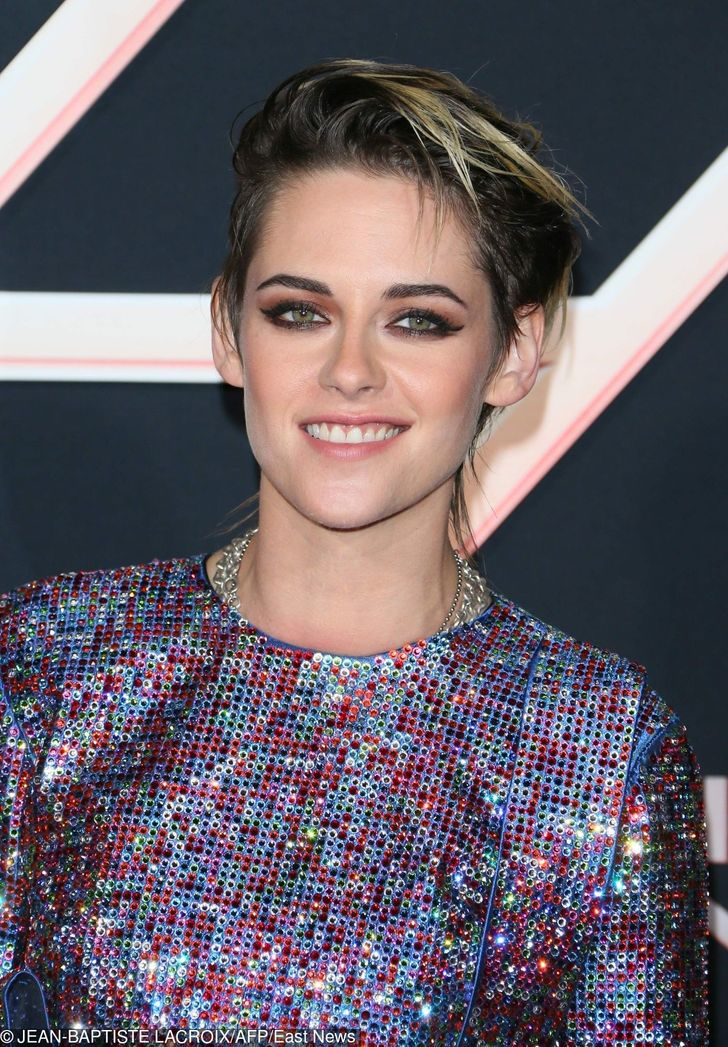

In [12]:
Image.open('../../All Content Image/collected_images/actor 1.jpg').convert('RGB')

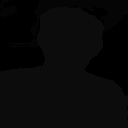

In [13]:
transforms.ToPILImage()(torch.argmax(logits, dim = 1).to(torch.float32)/255).convert('RGB')

In [14]:
extracted_inputs.pixel_values.shape

torch.Size([1, 3, 512, 512])

In [16]:
t1 = torch.rand((2,3,2,2))
torch.sum(torch.concat([t1[:,ind,:,:].unsqueeze(1) for ind in [0,2]], dim = 1), dim = 1).unsqueeze(1).shape

torch.Size([2, 1, 2, 2])

In [13]:
def image_imposition(original, styled_image, part = ['Hair'], size = (512,512), device = device, show = False, reverse_trans = None, original_trans = None, is_probab = True):

    # getting the index from the label to index
    indexes = [seg_config.label2id[f"{p}"] for p in part]

    # extracted inputs
    if type(original) != torch.Tensor:
        # print('inside wrong')
        extracted_inputs = extractor(images=original, return_tensors="pt")['pixel_values'].to(device)
    else:
        extracted_inputs = original

    # getting the outputs
    outputs = segmentation_model.to(device)(pixel_values = extracted_inputs)

    logits = outputs.logits

    # getting the logits
    if is_probab == False:
        logits = torch.softmax(logits, dim = 1)
        print(logits.max())

    # up-sampling the logits
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=size,
        mode="bilinear",
        align_corners=False,
    )

    # getting the required mask
    # mask = torch.where( torch.sigmoid(upsampled_logits[:,index,:,:].to(device)) > 0.3, 1.0, 0.0)
    mask = torch.clip(torch.sum(torch.concat([upsampled_logits[:,index,:,:].unsqueeze(1) for index in indexes], dim = 1), dim = 1),0,1).unsqueeze(1)
    print(mask.shape, mask.max())

    # for freeing memory
    del extracted_inputs, outputs
    del logits, upsampled_logits

    # style transforms to get back to normal image from vgg19 transformed image
    if reverse_trans is not None : styled_image = reverse_trans(styled_image)

    # now applying the hadamard product
    # so converting the original image to tensor
    if original_trans is not None: original_image = original_trans(original)
    else: original_image = original

    # print(original_image.shape, styled_image.shape, mask.shape)
    
    # getting the final image
    final_image = original_image * (1-mask) + styled_image.to(device) * (mask)  

    gc.collect()
    del original_image, styled_image, mask
    
    # showing the image
    if show:
        print(final_image.shape)
        img = transforms.ToPILImage()(final_image).convert('RGB')
        plt.imshow(img)
        plt.show()
    
    return final_image

In [14]:
def get_selective_style_transfer(image, transformer, save_dir, part = ['Hair'], size = (512,512), device = device, show = False,):

    # getting the styled_image :
    new_image = transforms.Resize((512,512))(image)
    new_image = ( transforms.ToTensor()(new_image)*2 - 1 ).unsqueeze(0)

    # styled_image
    style_image = transformer.to(device)(new_image.to(device)).squeeze()

    reverse_trans = transforms.Compose([
            transforms.Normalize(mean = -1, std = 1),
            transforms.Normalize(mean = 0, std = 2),
        ])

    # getting selective style transfer
    selective_styled_image = image_imposition(original = new_image*0.5 + 0.5, 
                                              styled_image = style_image, 
                                              part = part, 
                                              size = size, 
                                              device = device, 
                                              show = show, 
                                              reverse_trans = reverse_trans)
    
    # saving the image
    if save_dir is not None : 
        os.makedirs(save_dir['dir'], exist_ok = True)
        transforms.ToPILImage()(selective_styled_image).save(f"{save_dir['dir']}/{save_dir['name']}.png")

    return selective_styled_image

## Video style transfer

In [6]:
class video_folder_dataset(Dataset):

    def __init__(self, video = 'video obj', 
                 folder_path = './folder_path', 
                 transformations = transforms.ToTensor(),):

        # initializing variables
        if video is not None : self.video = video
        if folder_path is not None : self.folder = folder_path
        self.transformations = transformations

        # now getting the total frames from the video 
        if video is not None :
            self.len = int(self.video.get(cv.CAP_PROP_FRAME_COUNT))
        else:
            self.video = video
            self.images = []
            # getting all images path in a folder
            for name in os.listdir(folder_path):
                self.images.append( os.path.join(self.folder,name) )
            # length
            self.len = len(self.images)

    def __getitem__(self, index):
        
        if self.video is not None:
            # setting to that frame
            self.video.set(cv.CAP_PROP_POS_FRAMES, index)

            # reading the image
            ret, frame = self.video.read()
            image = Image.fromarray(frame).convert('RGB')
        
        else:
            # getting from the folder
            image = Image.open(self.images[index]).convert('RGB')

        if self.transformations is not None: image = self.transformations(image)
        # returning image
        return image

    def __len__(self):
        return self.len

In [7]:
def bulk_style_transfer(model, video_path, folder_path, batch_size, selective = None,
                        transformations =  transforms.ToTensor(), reverse_trans = None,
                        save_video = None, save_path = None, is_probab = True):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # getting the dataset
    image_dataset = DataLoader(dataset = video_folder_dataset(video = video_path, 
                                                            folder_path=folder_path,
                                                            transformations= transformations), 
                                                            batch_size = batch_size, shuffle=False, drop_last=False)
    
    transformed_images = []

    try :

        for index,batch in tqdm(enumerate(image_dataset), total = len(image_dataset)):
            
            try :
                # passing the image
                batch = batch.to(device)
                transformed_image = model(batch)

                # now doing the selective transformation
                if selective is not None:
                
                    transformed_image = image_imposition(original = batch, styled_image = transformed_image, 
                                                        part = selective, size = batch.shape[-2:], 
                                                        original_trans = reverse_trans,
                                                        device = device, show = False, 
                                                        reverse_trans = reverse_trans,
                                                        is_probab = is_probab)
                else:
                    transformed_image = reverse_trans(transformed_image)
                
                # appending it to the dataset
                transformed_images.append(transformed_image.detach().cpu())
                # print(transformed_image.shape)
                
                # for freeing memory
                del transformed_image, batch
                gc.collect()

            except Exception as e:
                print(f"error {e} at iteration : {index+1}")
                continue  

                # break  

    except Exception as e:
        print(f"error {e}- so ended iteration")  
    
    transformed_images = torch.concat(transformed_images, dim = 0)

    # checking if we need to save a video
    if save_video is not None:

        # object to save video
        h,w = transforms.ToPILImage()(transformed_images[0]).size
        fourcc = cv.VideoWriter_fourcc(*"XVID")
        video_writer = cv.VideoWriter(f"{save_video}.avi", fourcc, 24.0, (h, w)) 

        # writing image
        for img in tqdm(transformed_images):
            img_array = np.array(transforms.ToPILImage()(img).convert('RGB'), dtype = np.uint8)
            video_writer.write(img_array)
        
        # saving image
        video_writer.release()

        return transformed_images

    else:
        # making the dir
        os.makedirs(save_path, exist_ok = True)

        for i,v in tqdm(enumerate(transformed_images), desc = 'saving_images'):
            # saving the images
            transforms.ToPILImage()(v).convert('RGB').save(f"{save_path}{i}.jpg")
        
        return transformed_images

In [8]:
## Now testing the model
from source.all_models import Generator

In [9]:
net = Generator()
net.load_state_dict(torch.load('./weights/Shinkai.pt',map_location = device))

<All keys matched successfully>

In [6]:
# for cutting video

video = cv.VideoCapture('./videos/test-lunar-laner-1.mp4')
fps = video.get(cv.CAP_PROP_FPS)
total_frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))

start,end = [0*fps, 210*fps]
print(f"total frames : {end - start}")
img_save_path = f"./videos/test-lunar-lander-60-{start/fps}_{end/fps}.avi"

ret, frame = video.read()
h, w, _ = frame.shape

fourcc = cv.VideoWriter_fourcc(*"XVID")
trim_video_writer = cv.VideoWriter(img_save_path, fourcc, 60.0, (w, h)) 

f = 0
for i in tqdm(range(total_frames), total = total_frames):
    f += 1

    # writing the video
    if start <= f <= end:
        trim_video_writer.write(frame)
    elif f > end or ret == False:
        break
    ret, frame = video.read()
    # print(frame.dtype)
    # break

trim_video_writer.release()

# for i in tqdm(range(int(end-start))):

#     # getting the frames
#     frame_index = start + i
#     frame = video.set(cv.CAP_PROP_POS_FRAMES, frame_index)

#     # reading the image and writing it
#     ret, frame = video.read()
#     trim_video_writer.write(frame)

# cap.release()

total frames : 420.0


  0%|          | 0/473 [00:00<?, ?it/s]

In [34]:
new_video = cv.VideoCapture(img_save_path)
new_video.get(cv.CAP_PROP_FRAME_COUNT)

241.0

In [10]:
# other params
new_video = None

# folder_path = '../../All Content Image/collected_images/'
folder_path = './dataset/dataset/IIT Madras/'

# for image forward propagation
batch_size = 1
selective = None
size = (512,512)

# transformations
transformations = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0, std = 0.5),
    transforms.Normalize(mean = 1, std = 1),
])
reverse_trans = transforms.Compose([
            transforms.Normalize(mean = -1, std = 1),
            transforms.Normalize(mean = 0, std = 2),
            # transforms.ToPILImage(),
        ])

# save_video = './videos/Rajini/trailer_anime_120_face_protrait'
save_video = None
save_path = './selective_style_transfer/IIT Madras/Shinkai/'
is_probab = False

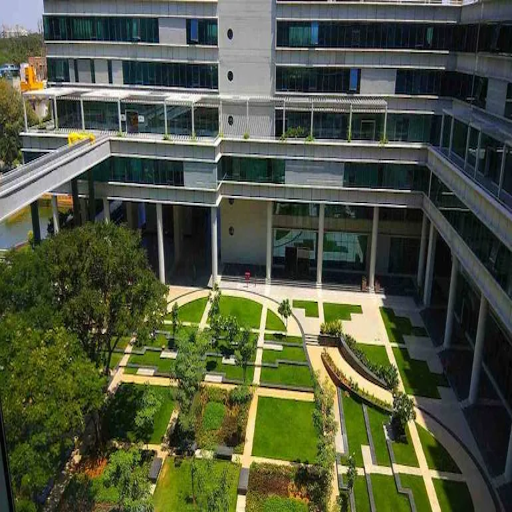

In [27]:
Image.open('./dataset/dataset/IIT Madras/13.webp').convert('RGB').resize(size)

In [15]:
transformed_images = bulk_style_transfer(model = net, 
                    video_path = new_video, 
                    folder_path = folder_path, 
                    batch_size = batch_size, 
                    selective = selective, 
                    transformations =  transformations, 
                    reverse_trans = reverse_trans,
                    save_video = save_video, 
                    save_path = save_path, 
                    is_probab = False)

  0%|          | 0/17 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

In [21]:
transforms.ToPILImage()(transformed_images[0]).size

(720, 480)

In [12]:
# object to save video
h,w = size
fourcc = cv.VideoWriter_fourcc(*"XVID")
video_writer = cv.VideoWriter(f"{save_video}.avi", fourcc, 24.0, (w, h)) 

# writing image
for img in tqdm(transformed_images):
    img_array = np.array(transforms.ToPILImage()(img).convert('RGB'), dtype = np.uint8)
    video_writer.write(img_array)
    # break

# saving image
video_writer.release()

In [23]:
new_video.release()

In [167]:
video_file = cv.VideoCapture('./videos/Rajini/trailer_anime_89_92.avi')

In [165]:
transforms.ToPILImage()(transformed_images[70]).convert('RGB').size

(380, 480)

In [15]:
# os.listdir('./videos/Rajini/face_protrait/')
# for joining videos

# fourcc = cv.VideoWriter_fourcc(*"XVID")
# face_video_writer = cv.VideoWriter('./videos/Rajini/face_protrait/ful_video.avi', fourcc, 24.0, (w, h)) 

# for video_path in tqdm(sorted(os.listdir('./videos/Rajini/face_protrait/'))):
    
#     # reading the path
#     path = os.path.join('./videos/Rajini/face_protrait/',video_path)
#     video_obj = cv.VideoCapture(f"{path}") # path

#     # now writing the video
#     ret = True
#     while ret:
#         ret, frame = video_obj.read()
#         face_video_writer.write(frame)

# face_video_writer.release()

## checking weights in tensorflow

In [9]:
import tensorflow as tf

In [15]:
reader = tf.train.load_checkpoint('./weights/checkpoint/generator_Hayao_weight/Hayao-99.ckpt')
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [17]:
os.path.exists('./weights/checkpoint/generator_Hayao_weight/Hayao-99.ckpt.data-00000-of-00001')

True

In [12]:
ckpt_vars = list(shape_from_key.keys())
reader.get_tensor(ckpt_vars[1]).shape

(7, 7, 3, 32)

In [13]:
shape_from_key.keys()

dict_keys(['generator/G_MODEL/C/LayerNorm/beta', 'generator/G_MODEL/A/Conv/weights', 'generator/G_MODEL/A/Conv_1/weights', 'generator/G_MODEL/A/LayerNorm_2/beta', 'generator/G_MODEL/C/r4/1/beta', 'generator/G_MODEL/C/r3/r3/w', 'generator/G_MODEL/A/Conv_2/weights', 'generator/G_MODEL/C/Conv_1/weights', 'generator/G_MODEL/C/r1/Conv/weights', 'generator/G_MODEL/A/LayerNorm_1/beta', 'generator/G_MODEL/A/LayerNorm/beta', 'generator/G_MODEL/A/LayerNorm_1/gamma', 'generator/G_MODEL/C/r1/r1/bias', 'generator/G_MODEL/A/LayerNorm/gamma', 'generator/G_MODEL/A/LayerNorm_2/gamma', 'generator/G_MODEL/C/r4/Conv/weights', 'generator/G_MODEL/B/Conv/weights', 'generator/G_MODEL/D/LayerNorm/beta', 'generator/G_MODEL/C/r4/r4/w', 'generator/G_MODEL/C/r4/Conv_1/weights', 'generator/G_MODEL/B/Conv_1/weights', 'generator/G_MODEL/C/r3/LayerNorm/gamma', 'generator/G_MODEL/C/r2/LayerNorm/beta', 'generator/G_MODEL/C/r4/r4/bias', 'generator/G_MODEL/C/r4/LayerNorm/beta', 'generator/G_MODEL/C/r1/r1/w', 'generator/G_

In [14]:
tf_model_mappings = []

for i in sorted(shape_from_key):

    tens = reader.get_tensor(i)

    if len(tens.shape) == 4:
        print(i,tens.transpose(3,2,0,1).shape)
        tf_model_mappings.append([i,tens.transpose(3,2,0,1)])
    else:
        print(i,tens.shape)
        tf_model_mappings.append([i,tens])

generator/G_MODEL/A/Conv/weights (32, 3, 7, 7)
generator/G_MODEL/A/Conv_1/weights (64, 32, 3, 3)
generator/G_MODEL/A/Conv_2/weights (64, 64, 3, 3)
generator/G_MODEL/A/LayerNorm/beta (32,)
generator/G_MODEL/A/LayerNorm/gamma (32,)
generator/G_MODEL/A/LayerNorm_1/beta (64,)
generator/G_MODEL/A/LayerNorm_1/gamma (64,)
generator/G_MODEL/A/LayerNorm_2/beta (64,)
generator/G_MODEL/A/LayerNorm_2/gamma (64,)
generator/G_MODEL/B/Conv/weights (128, 64, 3, 3)
generator/G_MODEL/B/Conv_1/weights (128, 128, 3, 3)
generator/G_MODEL/B/LayerNorm/beta (128,)
generator/G_MODEL/B/LayerNorm/gamma (128,)
generator/G_MODEL/B/LayerNorm_1/beta (128,)
generator/G_MODEL/B/LayerNorm_1/gamma (128,)
generator/G_MODEL/C/Conv/weights (128, 128, 3, 3)
generator/G_MODEL/C/Conv_1/weights (128, 256, 3, 3)
generator/G_MODEL/C/LayerNorm/beta (128,)
generator/G_MODEL/C/LayerNorm/gamma (128,)
generator/G_MODEL/C/LayerNorm_1/beta (128,)
generator/G_MODEL/C/LayerNorm_1/gamma (128,)
generator/G_MODEL/C/r1/1/beta (256,)
generato

In [56]:
tf_to_pytorch = {}

for name,p in net.named_parameters():
    
    tensor_shape = p.shape

    # searching the equivalent in tf
    for i,(tf_name,tf_param) in enumerate(tf_model_mappings):

        if tf_param.shape == tensor_shape:
            tf_to_pytorch[name] = tf_name

block_a.0.conv_norm_act_layer.1.weight torch.Size([32, 3, 7, 7])
block_a.0.conv_norm_act_layer.2.weight torch.Size([32])
block_a.0.conv_norm_act_layer.2.bias torch.Size([32])
block_a.1.conv_norm_act_layer.1.weight torch.Size([64, 32, 3, 3])
block_a.1.conv_norm_act_layer.2.weight torch.Size([64])
block_a.1.conv_norm_act_layer.2.bias torch.Size([64])
block_a.2.conv_norm_act_layer.1.weight torch.Size([64, 64, 3, 3])
block_a.2.conv_norm_act_layer.2.weight torch.Size([64])
block_a.2.conv_norm_act_layer.2.bias torch.Size([64])
block_b.0.conv_norm_act_layer.1.weight torch.Size([128, 64, 3, 3])
block_b.0.conv_norm_act_layer.2.weight torch.Size([128])
block_b.0.conv_norm_act_layer.2.bias torch.Size([128])
block_b.1.conv_norm_act_layer.1.weight torch.Size([128, 128, 3, 3])
block_b.1.conv_norm_act_layer.2.weight torch.Size([128])
block_b.1.conv_norm_act_layer.2.bias torch.Size([128])
block_c.0.conv_norm_act_layer.1.weight torch.Size([128, 128, 3, 3])
block_c.0.conv_norm_act_layer.2.weight torch.S

## Project euler

In [18]:
import math
 
def SieveOfEratosthenes(n, srt = 0):
    # Create a boolean array "prime[srt to n]" and
    # initialize all entries it as true. A value in
    # prime[i] will finally be false if i is Not a prime,
    # else true.
    prime = [True for i in range(n + 2 - srt)]
    prime[0] = False
    prime[1] = False
    prime_numbs = []
 
    for p in range(srt, int(math.sqrt(n))+1):
        # If prime[p] is not changed, then it is a prime
        if prime[p] == True:
            # Update all multiples of p greater than or
            # equal to the square of it numbers which are
            # multiple of p and are less than p^2 are
            # already been marked.
            for i in range(p*p, n+1, p):
                prime[i] = False
            # prime_numbs.append(p)
 
    # # Print all prime numbers
    for p in range(srt, n+1):
        if prime[p]:
            prime_numbs.append(p)
            
    return prime_numbs

In [42]:
# Quadratic Primes - 27

n_primes = SieveOfEratosthenes(n=int(997*997*2 + 997))
b_s = [ x for x in SieveOfEratosthenes(n=int(1e3)) if x >= 40 ]

In [43]:
b_s.__len__()

156

In [51]:
set_primes = set(n_primes)
max_observed = 40

for i,b in enumerate(b_s[0:]):

    possible_a = []

    # positive a 
    for j in range(0,1000,abs(b)):
        # possible_a.extend( [g for g in range(j,j+abs(b)-max_observed)] )
        possible_a.append(j)
    
    # negative a
    if b > 0:
        possible_a.extend([j for j in range(-1,-int(math.sqrt(4*(b)))-2,-1) ])

    # print(b,possible_a)
    # break

    for a_s in possible_a:

        # defining the n_numbers
        n_numbers = 0
        poly = lambda x: (x**2 + (a_s*x) + b) in set_primes
        
        while n_numbers < 150:

            if poly(n_numbers) == False:
                # print(b,a_s,n_numbers)
                max_observed = max(max_observed,n_numbers)
                if max_observed == n_numbers:
                    print(a_s*b, b, a_s, max_observed)
                break

            n_numbers += 1

print(max_observed)

-41 41 -1 41
-129 43 -3 42
-235 47 -5 43
-371 53 -7 44
-549 61 -9 45
-781 71 -11 46
-1079 83 -13 47
-1455 97 -15 48
-1921 113 -17 49
-2489 131 -19 50
-3171 151 -21 51
-3979 173 -23 52
-4925 197 -25 53
-6021 223 -27 54
-7279 251 -29 55
-8711 281 -31 56
-10329 313 -33 57
-12145 347 -35 58
-14171 383 -37 59
-16419 421 -39 60
-18901 461 -41 61
-21629 503 -43 62
-24615 547 -45 63
-27871 593 -47 64
-31409 641 -49 65
-35241 691 -51 66
-39379 743 -53 67
-43835 797 -55 68
-48621 853 -57 69
-53749 911 -59 70
-59231 971 -61 71
71


In [7]:
total_atoms = 0

for name,percent,mass in [['c',18.5,12], ['o',65,16], ['h',10,1], ['n',3.2,14]]:
    temp = (percent/100)*(50)*(6.023/(mass*1e-3))
    print(name,' - ',temp*1e23)
    total_atoms += temp

print('\n',total_atoms*1e23)

c  -  4.642729166666666e+26
o  -  1.2234218749999999e+27
h  -  3.0114999999999996e+27
n  -  6.8834285714285706e+25

 4.768029077380952e+27


In [11]:
print( (10**2.8)*6.023 )

3800.256085804202
